# CESM-LE drivers of phyto change

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
#from collections import OrderedDict
import xarray as xr
import numpy as np
#import dask
#from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
#style.use('ggplot')
import utils

### Get the CESM-LE variables (annual means calculated in cesm-le-annual-means-v2.ipynb)

In [41]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['Fe_avg_100m','SHF_QSW','phys_med_Fe','TEMP_100m_mean'] #,'Jint_100m_DIC','Fe_FLUX_IN_100m']

ds_list = []
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

Fe_avg_100m
SHF_QSW
phys_med_Fe
TEMP_100m_mean
CPU times: user 229 ms, sys: 10.1 ms, total: 240 ms
Wall time: 240 ms


In [42]:
ds.phys_med_Fe

<xarray.DataArray 'phys_med_Fe' (time: 181, member_id: 34, nlat: 384, nlon: 320)>
dask.array<open_dataset-086c1ef7a7ba0564dca7bbd19bfa8815phys_med_Fe, shape=(181, 34, 384, 320), dtype=float64, chunksize=(181, 34, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * time       (time) int64 1920 1921 1922 1923 1924 ... 2097 2098 2099 2100
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Dissolved Inorganic Iron Tendency Vertical Integral, 0-100m
    units:         mmol/m^3 cm/s
    grid_loc:      2110
    cell_methods:  time: mean

### calculate PAR and Fix units

In [43]:
ds['PAR_surf'] = ds['SHF_QSW'] * 0.45

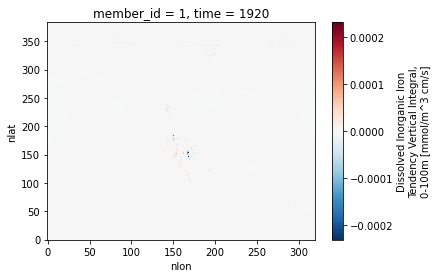

In [44]:
ds.phys_med_Fe.isel(time=0,member_id=0).plot()

In [45]:
convert = 0.01 * 86400. * 1000. *1000. #converting from mmol/m3 cm/s to nmol/m2/d
ds['phys_med_Fe'] = ds.phys_med_Fe * convert
ds.phys_med_Fe.attrs['units'] = 'µmol/m^2/d'

In [46]:
variables = ['Fe_avg_100m','PAR_surf','phys_med_Fe']

### get pop grid

In [47]:
grid = pop_tools.get_grid('POP_gx1v6')

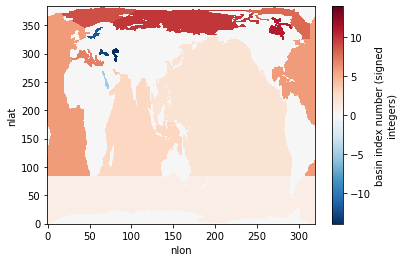

In [48]:
grid.REGION_MASK.plot()

In [49]:
lons = grid.TLONG
lats = grid.TLAT
area = grid.TAREA
years = ds.time.values
years

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 20

### mask out nans in ds

In [50]:
ds = ds.where(grid.REGION_MASK>0)

### extract 1920s

In [51]:
ds.time.isel(time=slice(0,10)).values

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929])

In [52]:
ds_1920s = ds.isel(time=slice(0,10)).mean(dim='time')

### extract 1990s

In [53]:
ds.time.isel(time=slice(70,80)).values

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999])

In [54]:
ds_1990s = ds.isel(time=slice(70,80)).mean(dim='time')

### Extract 2090s

In [55]:
ds.time.isel(time=slice(-11,-1)).values

array([2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])

In [56]:
ds_2090s = ds.isel(time=slice(-11,-1)).mean(dim='time')

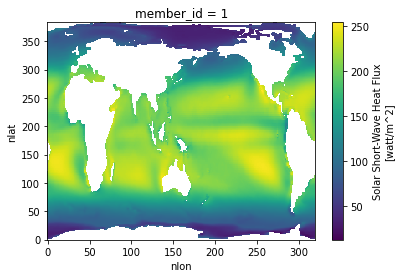

In [57]:
ds_2090s.SHF_QSW.isel(member_id=0).plot()

### calculate ensemble means

In [58]:
ensemble_mean_1920s = ds_1920s.mean(dim='member_id')
ensemble_mean_1990s = ds_1990s.mean(dim='member_id')
ensemble_mean_2090s = ds_2090s.mean(dim='member_id')

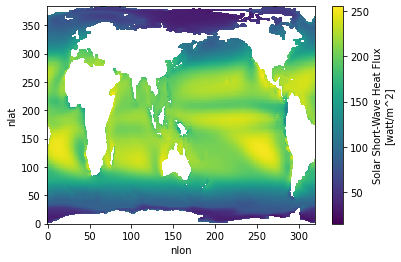

In [59]:
ensemble_mean_2090s.SHF_QSW.plot()

In [60]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1990s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

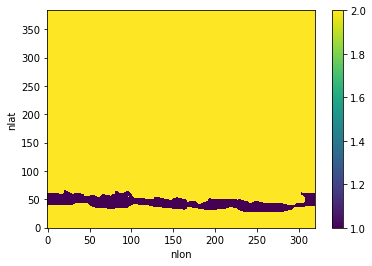

In [61]:
outside=np.full((384, 320), 2)

inside = ds_masks.ACC_mask.where(ds_masks.ACC_mask ==1)
inside = np.asarray(inside)

outside[~np.isnan(inside)] = inside[~np.isnan(inside)]

ACC=xr.DataArray(outside)
ACC=ACC.rename({'dim_0':'nlat'})
ACC=ACC.rename({'dim_1':'nlon'})
ACC.plot()

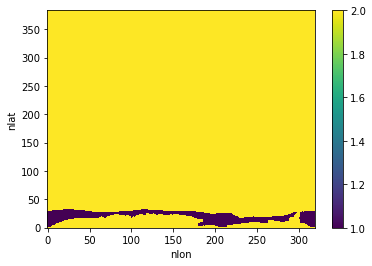

In [62]:
outside=np.full((384, 320), 2)

inside = ds_masks.SIZ_mask.where(ds_masks.SIZ_mask ==1)
inside = np.asarray(inside)

outside[~np.isnan(inside)] = inside[~np.isnan(inside)]

SIZ=xr.DataArray(outside)
SIZ=SIZ.rename({'dim_0':'nlat'})
SIZ=SIZ.rename({'dim_1':'nlon'})
SIZ.plot()

## make zonal means of SW and Fe change

In [63]:
zonal_1920s = ensemble_mean_1920s.isel(nlat=slice(0,93)).mean(dim='nlon')
zonal_1990s = ensemble_mean_1990s.isel(nlat=slice(0,93)).mean(dim='nlon')
zonal_2090s = ensemble_mean_2090s.isel(nlat=slice(0,93)).mean(dim='nlon')
lats_zonal = lats.isel(nlat=slice(0,93)).mean(dim='nlon')

In [64]:
zonal_1920s

<xarray.Dataset>
Dimensions:         (nlat: 93, z_t: 60)
Dimensions without coordinates: nlat, z_t
Data variables:
    KMT             (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    TAREA           (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    dz              (z_t, nlat) float32 dask.array<chunksize=(60, 93), meta=np.ndarray>
    Fe_avg_100m     (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    SHF_QSW         (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    phys_med_Fe     (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    TEMP_100m_mean  (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>
    PAR_surf        (nlat) float64 dask.array<chunksize=(93,), meta=np.ndarray>

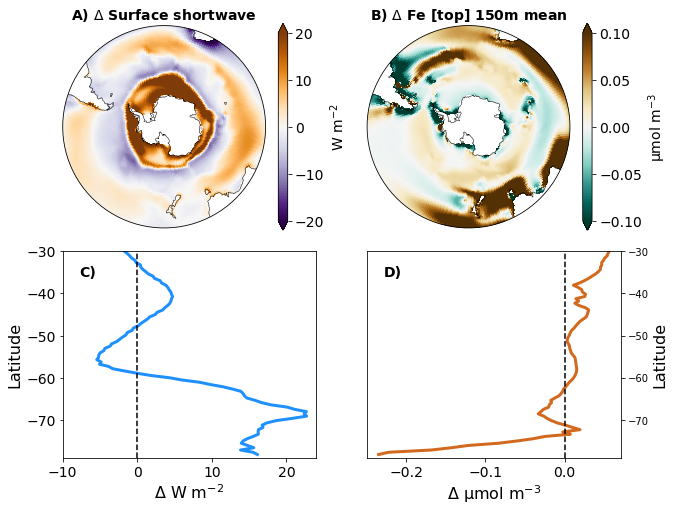

In [65]:
fig = plt.figure(figsize=(10,8))


#################################################################### plot SW map change
ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_title('A) ${\Delta}$ Surface shortwave', fontsize=14, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
lon, lat, field = utils.adjust_pop_grid(lons, lats, ensemble_mean_2090s['SHF_QSW'] - ensemble_mean_1920s['SHF_QSW'])
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-20, vmax=20, 
                 cmap='PuOr_r',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='W m$^{-2}$',size=14)
cbar1.ax.tick_params(labelsize=14)

################################################################### plot Fe change map
ax = fig.add_subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('B) ${\Delta}$ Fe [top] 150m mean',fontsize=14, fontweight='bold')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
lon, lat, field = utils.adjust_pop_grid(lons, lats, (ensemble_mean_2090s.Fe_avg_100m- ensemble_mean_1920s.Fe_avg_100m) * 1000.)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
pc=ax.pcolormesh(lon, lat, 
                 field, 
                 vmin=-0.1, vmax=0.1, 
                 #vmin=0.000001,vmax=0.0001,
                 cmap='BrBG_r',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both')
cbar1.set_label(label='µmol m$^{-3}$',size=14)
cbar1.ax.tick_params(labelsize=14)

################################# zonal SW change
ax = fig.add_subplot(2,2,3)

ax.set_ylim(-79,-30)
ax.set_xlim(-10,24)
ax.set_title('C)', x=0.1, y=0.85, fontsize=14,fontweight='bold')
ax.plot(zonal_2090s['SHF_QSW']-zonal_1920s['SHF_QSW'],lats_zonal,  label='surface SW', linewidth=3, color='dodgerblue')
plt.axvline(x=0,color='black',linestyle='--')
ax.set_ylabel(ylabel='Latitude',fontsize=16)
ax.set_xlabel(xlabel='${\Delta}$ W m$^{-2}$',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.locator_params(axis='x', nbins=4)

### SW light
ax = fig.add_subplot(2,2,4)

ax.set_ylim(-79,-30)
#ax.set_xlim(-10,24)
ax.set_title('D)', x=0.1, y=0.85, fontsize=14,fontweight='bold')
ax.plot(zonal_2090s['Fe_avg_100m']*1000.-zonal_1920s['Fe_avg_100m']*1000.,lats_zonal,  label='[Fe]', linewidth=3, color='chocolate')
plt.axvline(x=0,color='black',linestyle='--')
ax.set_ylabel(ylabel='Latitude',fontsize=16)
ax.set_xlabel(xlabel='${\Delta}$ µmol m$^{-3}$',fontsize=16) #or nM!!
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.locator_params(axis='x', nbins=4)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right();


fig.subplots_adjust(hspace=0.1)


#fig.savefig('/glade/work/kristenk/figs/change_maps_zonals_in_SW_Fe.png', bbox_inches='tight', dpi=300, format='png');


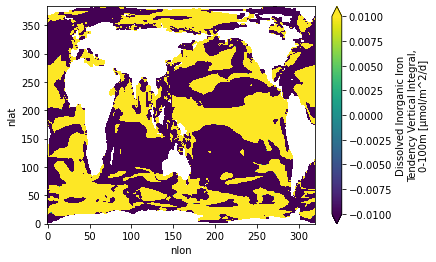

In [66]:
diff = ensemble_mean_2090s.phys_med_Fe - ensemble_mean_1920s.phys_med_Fe
diff.plot(vmin=-0.01,vmax=0.01)

CPU times: user 28.5 s, sys: 1min 1s, total: 1min 29s
Wall time: 1min 27s


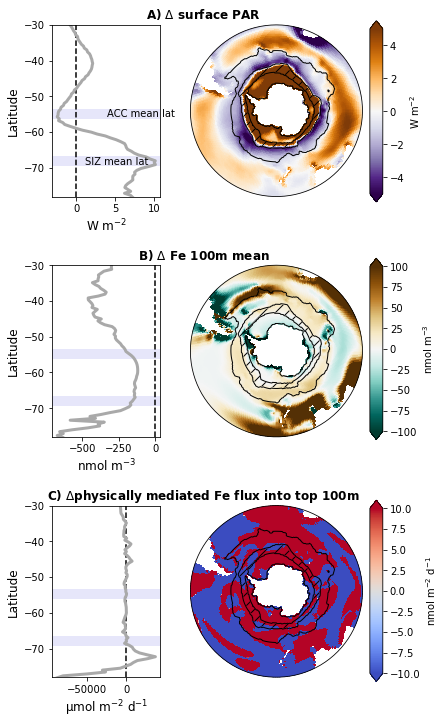

In [67]:
%%time

fig = plt.figure(constrained_layout=True,figsize=(6,12))
ax = fig.add_gridspec(3, 3)

#########################################################################################

ax1 = fig.add_subplot(ax[0,0:1])
ax1.set_ylim(-78,-30)
ax1.set_title('A) ${\Delta}$ surface PAR', x=1.4, fontsize=12,  fontweight='bold')
plt.axhline(y=-54.8,color='lavender',linestyle='-',linewidth=10) #mean latitude of ACC region
plt.axhline(y=-68,color='lavender',linestyle='-',linewidth=10) #mean latitude of SIZ region
ax1.annotate('ACC mean lat', xy=(4, -55.8))
ax1.annotate('SIZ mean lat', xy=(1.2, -69.2))
plt.axvline(x=0,color='black',linestyle='--')
ax1.plot(zonal_2090s['PAR_surf']-zonal_1920s['PAR_surf'],lats_zonal,  label='2090s', linewidth=3, color='darkgray')
ax1.set_ylabel(ylabel='Latitude',fontsize=12)
ax1.set_xlabel(xlabel='W m$^{-2}$',fontsize=12)
plt.xticks(fontsize=10)



ax1 = fig.add_subplot(ax[0,1:3], projection=ccrs.SouthPolarStereo())
#ax1.set_title('A) ${\Delta}$SW',fontsize=12, fontweight='bold',x=0.3)
ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax1.set_boundary(circle, transform=ax1.transAxes)
#################### end circle
diff = ensemble_mean_2090s.PAR_surf - ensemble_mean_1920s.PAR_surf
lon, lat, field = utils.adjust_pop_grid(lons, lats,diff)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
pc=ax1.pcolormesh(lon, lat,field, 
                 vmin=-5, vmax=5, 
                 cmap='PuOr_r',
                 transform=ccrs.PlateCarree())
## SIZ
lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax1.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=1)

### ACC
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax1.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=1)

### marginal SIZ
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax1.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar_ax = fig.add_axes([0.86, 0.675, 0.03, 0.21])
cbar1 = fig.colorbar(pc, extend='both', cax=cbar_ax, label='W m$^{-2}$');
#########################################################################################


ax1 = fig.add_subplot(ax[1,0:1])
ax1.set_ylim(-78,-30)
#ax.set_xlim(-0.1,0.1)
ax1.set_title('B) ${\Delta}$ Fe 100m mean', x=1.4, fontsize=12,  fontweight='bold')
plt.axhline(y=-54.8,color='lavender',linestyle='-',linewidth=10) #mean latitude of ACC region
plt.axhline(y=-68,color='lavender',linestyle='-',linewidth=10) #mean latitude of SIZ region
plt.axvline(x=0,color='black',linestyle='--')
ax1.plot(zonal_2090s['Fe_avg_100m']**1.e6-zonal_1920s['Fe_avg_100m']*1.e6,lats_zonal,  label='2090s', linewidth=3, color='darkgray')
ax1.set_ylabel(ylabel='Latitude',fontsize=12)
ax1.set_xlabel(xlabel='nmol m$^{-3}$',fontsize=12)
plt.xticks(fontsize=10)


ax1 = fig.add_subplot(ax[1,1:3], projection=ccrs.SouthPolarStereo())
#ax1.set_title('B) ${\Delta}$Fe',fontsize=12, fontweight='bold',x=0.3)
ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
#################### end circle
diff = ensemble_mean_2090s.Fe_avg_100m - ensemble_mean_1920s.Fe_avg_100m
lon, lat, field = utils.adjust_pop_grid(lons, lats,diff * 1.e6)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
pc=ax1.pcolormesh(lon, lat,field, 
                 vmin=-100, vmax=100, 
                 cmap='BrBG_r',
                 transform=ccrs.PlateCarree())
## SIZ
lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax1.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=1)

### ACC
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax1.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=1)

### marginal SIZ
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax1.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar_ax = fig.add_axes([0.86, 0.40, 0.03, 0.21])
cbar1 = fig.colorbar(pc, extend='both', cax=cbar_ax, label='nmol m$^{-3}$');
#########################################################################################

ax1 = fig.add_subplot(ax[2,0:1])
ax1.set_ylim(-78,-30)
#ax.set_xlim(-0.1,0.1)
ax1.set_title('C) ${\Delta}$physically mediated Fe flux into top 100m', x=1.4, fontsize=12,  fontweight='bold')
plt.axhline(y=-54.8,color='lavender',linestyle='-',linewidth=10) #mean latitude of ACC region
plt.axhline(y=-68,color='lavender',linestyle='-',linewidth=10) #mean latitude of SIZ region
plt.axvline(x=0,color='black',linestyle='--')
ax1.plot((zonal_2090s['phys_med_Fe']-zonal_1920s['phys_med_Fe'])*1000.,lats_zonal,  label='2090s', linewidth=3, color='darkgray')
ax1.set_ylabel(ylabel='Latitude',fontsize=12)
ax1.set_xlabel(xlabel='µmol m$^{-2}$ d$^{-1}$',fontsize=12)
plt.xticks(fontsize=10)


ax1 = fig.add_subplot(ax[2,1:3], projection=ccrs.SouthPolarStereo())
#ax1.set_title('C) ${\Delta}$Fe flux at 100m',fontsize=12, fontweight='bold',x=0.3)
ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
#################### end circle

diff = ensemble_mean_2090s.phys_med_Fe - ensemble_mean_1920s.phys_med_Fe
lon, lat, field = utils.adjust_pop_grid(lons, lats,diff*1000.)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
pc=ax1.pcolormesh(lon, lat,field, 
                 vmin=-10, vmax=10, 
                 cmap='coolwarm',
                 transform=ccrs.PlateCarree())
## SIZ
lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax1.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=1)

### ACC
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax1.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=1)

### marginal SIZ
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax1.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar_ax = fig.add_axes([0.86, 0.12, 0.03, 0.21])
cbar1 = fig.colorbar(pc, extend='both', cax=cbar_ax, label='nmol m$^{-2}$ d$^{-1}$');
plt.subplots_adjust(hspace=0.4,wspace=0.05)

#fig.savefig('/glade/work/kristenk/figs/change_maps_zonals_3drivers.png', bbox_inches='tight', dpi=300, format='png');

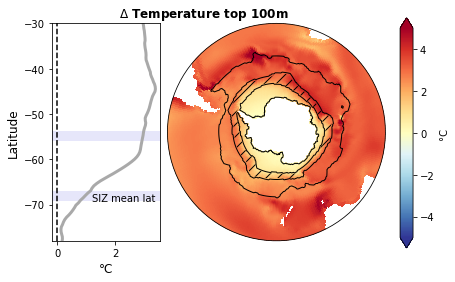

In [40]:
fig = plt.figure(constrained_layout=True,figsize=(6,4))
ax = fig.add_gridspec(1, 3)

#########################################################################################

ax1 = fig.add_subplot(ax[0:1])
ax1.set_ylim(-78,-30)
ax1.set_title('${\Delta}$ Temperature top 100m', x=1.4, fontsize=12,  fontweight='bold')
plt.axhline(y=-54.8,color='lavender',linestyle='-',linewidth=10) #mean latitude of ACC region
plt.axhline(y=-68,color='lavender',linestyle='-',linewidth=10) #mean latitude of SIZ region
ax1.annotate('ACC mean lat', xy=(4, -55.8))
ax1.annotate('SIZ mean lat', xy=(1.2, -69.2))
plt.axvline(x=0,color='black',linestyle='--')
ax1.plot(zonal_2090s['TEMP_100m_mean']-zonal_1920s['TEMP_100m_mean'],lats_zonal,  label='2090s', linewidth=3, color='darkgray')
ax1.set_ylabel(ylabel='Latitude',fontsize=12)
ax1.set_xlabel(xlabel='°C',fontsize=12)
plt.xticks(fontsize=10)



ax1 = fig.add_subplot(ax[1:3], projection=ccrs.SouthPolarStereo())
#ax1.set_title('A) ${\Delta}$SW',fontsize=12, fontweight='bold',x=0.3)
ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax1.set_boundary(circle, transform=ax1.transAxes)
#################### end circle
diff = ensemble_mean_2090s.TEMP_100m_mean - ensemble_mean_1920s.TEMP_100m_mean
lon, lat, field = utils.adjust_pop_grid(lons, lats,diff)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
pc=ax1.pcolormesh(lon, lat,field, 
                 vmin=-5, vmax=5, 
                 cmap='RdYlBu_r',
                 transform=ccrs.PlateCarree())
## SIZ
lon, lat, field = utils.adjust_pop_grid(lons, lats, SIZ)
pci=ax1.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=1)

### ACC
lon, lat, field = utils.adjust_pop_grid(lons, lats, ACC)
pci=ax1.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=1)

### marginal SIZ
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_masks.marginal_SIZ_mask)
pci=ax1.contourf(lon, lat, field,levels=[0.1,0.85],transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

cbar_ax = fig.add_axes([0.93, 0.1, 0.03, 0.8])
cbar1 = fig.colorbar(pc, extend='both', cax=cbar_ax, label='°C');
plt.subplots_adjust(hspace=0.4,wspace=0.05)